# Titanic disaster model

### Inrotuction
#### to do:
- briefly describe model
- talk about recent methods used for problems like this\
- talk about methods we want to use
- what do we expect

https://www.kaggle.com/competitions/titanic

https://www.kaggle.com/code/alexisbcook/titanic-tutorial/notebook

https://www.overleaf.com/read/fqxnygwqtnjs#fbe3c8

### Seting up environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from scipy import optimize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize, LinearConstraint

### About the dataset
The dataset used in the project was downloaded from github repository provided by Kaggle: https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/. 

It came with data dictionary with definitions of values and keys of the dataset. From left variables were as fallows: survival - Survival result (0 = No, 1 = Yes), Pclass	- ticket class	(1 = 1st, 2 = 2nd, 3 = 3rd), Sex - sex,
Age	   -     age in years, 
Sibsp	-    number of siblings / spouses aboard the Titanic, 	
Parch	-     number of parents / children aboard the Titanic	
Ticket	-    ticket number, 
Fare	-    passenger fare	
Cabin	-    cabin number	
Embarked -	port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton.




In [2]:
gh_path = 'https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/'
df_train = pd.read_csv(gh_path + 'train.csv')
df_test = pd.read_csv(gh_path + 'test.csv')
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Feature engineering
Main task in this section was to prepare dataset for modeling. It was necessary to remove certain features that were redundant, that is "Name", "Ticket", "Cabin" and "Embarked". It was concluded, that name of the passenger, port of embarkation, ticket and cabin number were meaningless for analysis. Nevertheless, we concluded, that cabin placement on ship might have had influence on priority over reaching the lifeboats. Information about cabin placement could be hidden in ticket's fare,. This feature was left in dataset to include passenger placement in model.

Another change that had to be made was the change of sex's values from string to binary. In the project attributes for male and female were assigned to 0 and 1 respectively.

Last thing that was done, was the drop of keys with missing values. 

In [53]:
# Drop unnecessary columns
columns_to_drop = ['Name','Ticket', 'Cabin', 'Embarked']
df_train_processed = df_train.drop(columns=columns_to_drop)
df_test_processed = df_test.drop(columns=columns_to_drop)

# Drop keys with any NaN values
df_train_processed = df_train_processed.dropna()

# Change nan values for statisticaly correct values
average_age = df_test_processed['Age'].mean()
df_test_processed['Age'].fillna(average_age, inplace=True)

average_fare_train = df_test_processed['Fare'].mean()
df_test_processed['Fare'].fillna(average_fare_train, inplace=True)

# Sex changed to binary
df_train_processed['Sex'] = df_train_processed['Sex'].replace({'male': 0, 'female': 1})
df_test_processed['Sex'] = df_test_processed['Sex'].replace({'male': 0, 'female': 1})

print(df_train_processed)

     PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare
0              1         0       3    0  22.0      1      0   7.2500
1              2         1       1    1  38.0      1      0  71.2833
2              3         1       3    1  26.0      0      0   7.9250
3              4         1       1    1  35.0      1      0  53.1000
4              5         0       3    0  35.0      0      0   8.0500
..           ...       ...     ...  ...   ...    ...    ...      ...
885          886         0       3    1  39.0      0      5  29.1250
886          887         0       2    0  27.0      0      0  13.0000
887          888         1       1    1  19.0      0      0  30.0000
889          890         1       1    0  26.0      0      0  30.0000
890          891         0       3    0  32.0      0      0   7.7500

[714 rows x 8 columns]


Processed train dataset was next splited into training and testing sets using train_test_split functntion:

In [54]:
Y = df_train_processed['Survived'].values
X = df_train_processed[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=420)

### Perceptron

#### To do:
- define weight vector W (imo randomly) and training set X
- DONE definition of perceptron class (linear, binary[if survived would be changed to -1 and 1] or/and LOGISTIC). That would include: activation function, loss function, fiting (gradient descent/newton-rap), all can be copied and slightly modified form collab "logistic_regression_and_svm",
- spliting training dataset and look for bad predictions,
- comparason with scikit-learn method

In [9]:
class PerceptronLogistic:
    def __init__(self, W : np.array,  b = 0, epo = 100, lr = 0.01):
        self.W = W
        self.N = len(W)
        self.b = b
        # how many learning iterations we give
        self.epo = epo
        # what is our step in the gradient
        self.lr = lr
    def get_N(self):
        return self.N
    
    def get_b(self):
        return self.b
    
    def get_W(self):
        return self.W
    
    ############################## SETTERS ##############################
    
    # Create setters for the perceptron
    def set_N(self, N):
        self.N = N
        self.W = np.zeros(N)
        
    def set_b(self, b):
        self.b = b
        
    def set_W(self, W : np.array):
        if W.ndim != 1:
            print("Cannot set such weights -> dimension wrong")
            return
        self.N = W.shape[0]
        self.W = W
    
    def set_lr(self, lr):
        self.lr = lr
        
    def set_epo(self, epo):
        self.epo = epo
    ############################## GETTERS OVERRIDE ##############################
    
    def __getitem__(self, key):
        return self.W[key]
    
    def __setitem__(self, key, value):
        self.W[key] = value
        
    def __getslice(self, i, j):
        return self.W[i:j]
    
    def get_lr(self):
        return self.lr

    def get_epo(self):
        return self.epo
    
    # set the string output of the perceptron 
    def __str__(self):
        return f"Am a perceptron of N={self.N} dimension{'s' if self.N > 1 else ''} biased with b={self.b}"    

    ############################## OPERATORS OVERRIDE ##############################
     
    def __mul__(self, other):
        return self.activation_function(other)
    
    def __rmul__(self, other):
        return self.__mul__(other)

    ############################## PERCEPTRON METHODS ##############################
    
    '''
    Net output is the basic body action of the perceptron. On top of it, the activation function is used.
    '''
    def net_output(self, X):
        return np.dot(X, self.W) + self.b

    def activation_function(self, X):
        return (1.0/(1.0+np.exp(-self.net_output(X)))).reshape(-1,1)
    
    def loss(self, y_true : np.array, y_pred : np.array):
        return -np.sum(np.multiply(y_true, np.log(y_pred)) + np.multiply((1.0-y_true), np.log(1.0-y_pred)))

    def gradient(self, x_true, y_true, prediction):
        val = y_true - prediction
        suma_w = np.multiply(val, x_true)
        suma_b = val         
        return suma_b, suma_w

    def predict(self, X):
        return self.activation_function(X)    

    def fit(self, X, y, randomstate = None, batch = 1, verbose = False):
        '''
        Fit function allows to obtain the (probably most?) correct weights for the perceptron via the gradient descent algorithm.
        '''
        
        if type(X) != np.ndarray:
            X = np.array(X)
        if type(y) != np.ndarray:
            y = np.array(y).reshape(-1,1)
            
        # give fit the parameter randomstate and whenever it is not None, the weights
        # are reset to be random normal - this ensures random starting point of gradient descent
        if randomstate is not None:
            self.W = np.random.normal(0.0, 0.1, self.N)
            self.b = np.random.normal(0.0, 1.0)
        
        # Save the history of the losses. Why?
        history = []
        # If we want to calculate the gradient in buckets (look for description of the batch)
        bucket_num = len(X) // batch
        # slice the data onto batches without shuffling (no stochasticity)
        slicing = lambda x, b: x[(b-1)*batch:b*batch]
        
        # iterate epochs
        for epo in range(self.epo):
            # iterate batches
            loss = 0.0
            for bin in range(1, bucket_num + 1):
                X_slice = slicing(X,bin)
                y_slice = slicing(y,bin)
                # predict the output for a given slice (what is the shape of the output?)
                pred = self.predict(X_slice)
                
                suma_b, suma_w = self.gradient(X_slice, y_slice, pred.flatten())

                # calculate loss
                loss += self.loss(y_slice, pred.flatten())
                
                # update the weights
                self.W += np.mean(suma_w, axis = 0) * self.lr
                self.b += np.mean(suma_b, axis = 0) * self.lr 
            # calculate average loss
            loss/=bucket_num
            if verbose:
                print(f'epo:{epo}->loss={loss}')        
            history.append(loss.flatten())
        return np.array(history).flatten()
    
    def plot_history(self, history, ax = None):
        '''
        Basic history plot
        '''        
        if ax is None:
            fig, ax = plt.subplots()
        ax.set_xlabel('epo')
        ax.set_ylabel('loss')
        ax.plot(history)

In [6]:
#skylearn attempt


### Suport Vector Machine

Support Vector Machine (SVM) is a supervised machine learning algorithm used for classification and regression tasks. It is commonly used in classification problems where occur non-linear decision boundaries.  It aims to find the optimal hyperplane that separates different classes in the input space. In project, vectors are in 6-th dimention (described by 6 values: Pclass, Sex, Age, SibSp, Parch and Fare). Support vectors are data points from each class that are closest to the hyperplane. They play a crucial role in determining the optimal hyperplane and maximizing the margin between classes - the distance between the hyperplane and the nearest data point from each class.

There was unsuccesfull attempt to implement SVM class from scratch. A Decision was made to implement model using only scikit-learn package functions. Nevertheless, different kernel functions were used: linear, polynomial, radial basis function (RBF) and sigmoid function.

In [39]:
### linear kernel
svm_model = SVC(kernel='linear')  #try different kernels
svm_model.fit(X_train, Y_train)

# making predictions on the test set
predictions = svm_model.predict(X_test)

# evaluating accuracies
accuracy = svm_model.score(X_test, Y_test)
print(f"Accuracy of linear kernel SVM: {accuracy}")

Accuracy of linear kernel SVM: 0.8333333333333334


In [15]:
### poly kernel
svm_model = SVC(kernel='poly')  #try different kernels
svm_model.fit(X_train, Y_train)
predictions = svm_model.predict(X_test)
accuracy = svm_model.score(X_test, Y_test)
print(f"Accuracy of poly kernel SVM: {accuracy}")

Accuracy of poly kernel SVM: 0.6388888888888888


In [16]:
### Radial Basis Function kernel
svm_model = SVC(kernel='rbf')  #try different kernels
svm_model.fit(X_train, Y_train)
predictions = svm_model.predict(X_test)
accuracy = svm_model.score(X_test, Y_test)
print(f"Accuracy of Radial Basis Function kernel SVM: {accuracy}")

Accuracy of Radial Basis Function kernel SVM: 0.6574074074074074


In [55]:
### sigmoid kernel
svm_model = SVC(kernel='sigmoid')  #try different kernels
svm_model.fit(X_train, Y_train)
predictions = svm_model.predict(X_test)
accuracy = svm_model.score(X_test, Y_test)
print(f"Accuracy of sigmoid kernel SVM: {accuracy}")

Accuracy of sigmoid kernel SVM: 0.6203703703703703


Best accuracy was reached for linear kernel SVM, and it was used for final prediction for Kaggle competition.

In [59]:
# save the results
predictions = svm_model.predict(df_test_processed[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].values)
output = pd.DataFrame({'PassengerId': df_test_processed.PassengerId, 'Survived': predictions})
output.to_csv('SVM_kaggle_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


![Alt text](SVM-score.png)

#### Random Forest Model
##### To do:
- arono

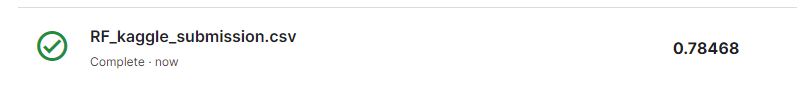

##### Random forest (kaggle example)

In [26]:
from sklearn.ensemble import RandomForestClassifier
test_data = df_test
y = df_train["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(df_train[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

accuracy = model.score(X, y)
print(f"Accuracy of Random Forest Classifier: {accuracy}")

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('RF_kaggle_submission.csv', index=False)
print("Your submission was successfully saved!")

Accuracy of Random Forest Classifier: 0.8159371492704826
Your submission was successfully saved!


#### Principal component analysis (PCA)
PCA is a dimensionality reduction technique commonly used in machine learning and statistics. Its goal is to transform high-dimensional data into a lower-dimensional image while conserving as much of original variability as posibible. PCA achieves this by identifying the principal components, which are linear combinations of the original features that capture the maximum variance in the data.

PCA was preform using sklearn package. In order to increase values of principal components, additional features were removed: "PassengerId", "SibSp", "Parch" and "Fare". Data was then standarized.

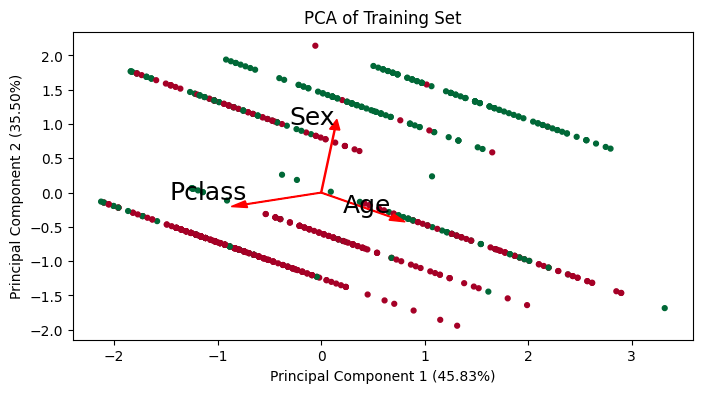

In [84]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# dropping unnecessary columns before PCA
columns_to_drop = ["PassengerId","SibSp", "Parch",'Fare']
df_train_pca = df_train_processed.drop(columns=columns_to_drop)
X_train = df_train_pca.drop(columns=['Survived'])
y_train = df_train_pca['Survived']


# standardizing features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
#preforming pca
n_components = 2
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_standardized)
components = pca.components_

# ploting
explained_variance_ratio = pca.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='RdYlGn',s=12)
plt.title('PCA of Training Set')
plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]*100:.2f}%)')

# labeling and adding arrows for original features
feature_names = X_train.columns
for i, (pc1, pc2) in enumerate(zip(components[0], components[1])):
    plt.text(pc1, pc2, feature_names[i], fontsize=18, ha='right', va='bottom')
    plt.arrow(0, 0, pc1, pc2, color='r', width=0.01, head_width=0.1)

plt.show()

First two components cover around 81% of data's variance, which is good result. One can conclude, that most of the women survived, while most of the man died in disaster. Unfortunately young age wasn't decisive factor for survival - some children did not survive (mostly form 3rd class). In terms of class membership, females from 3rd class had lower survivalability and some 1st class males managrd to survive.

#### Summary
To do:
- did we reachedour goals?
- what is interesting in our solutions
- what could be done better? limits and possible improvement